In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import scipy.stats as stats
%matplotlib inline
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.activations import relu, softmax
import cv2


In [26]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [27]:
print(df_train.head())
print(df_test.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
  image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4


In [28]:
print(df_train.info())
print(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1821 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB
None


In [38]:

directory = 'images/'
img = []

for files in os.listdir(directory):
    if files.startswith('Train'):
        image = cv2.imread(directory+files)
        res = cv2.resize(image, (256,256))
        img.append(res)
    
img = np.array(img)
img.shape

(1821, 256, 256, 3)

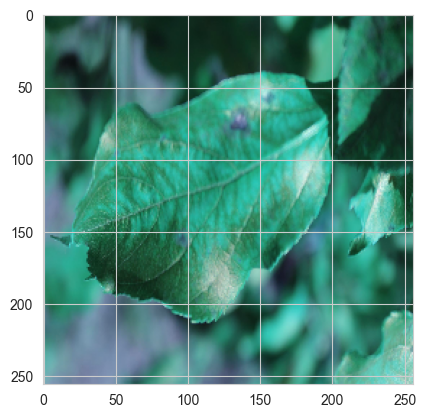

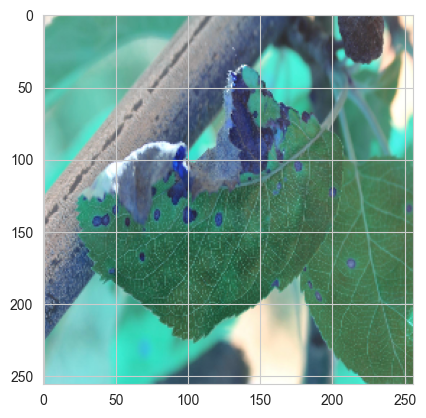

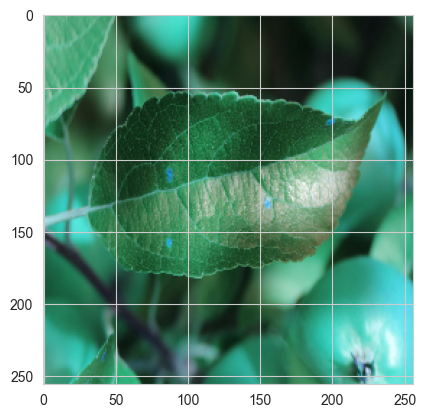

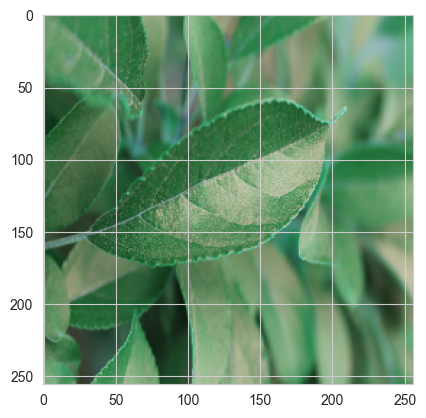

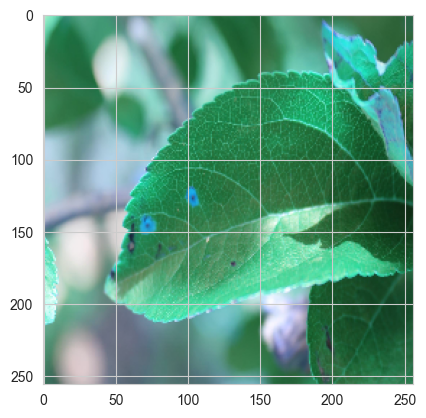

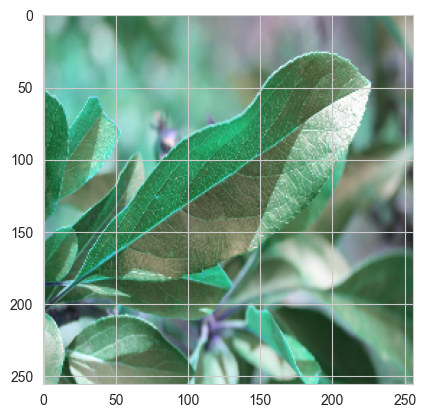

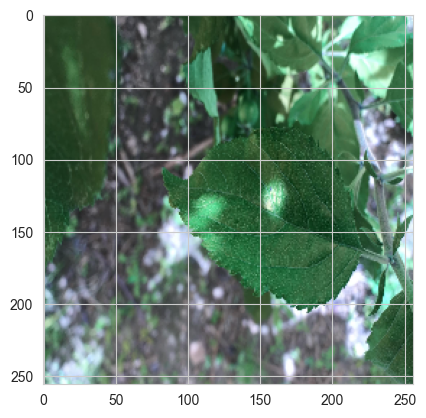

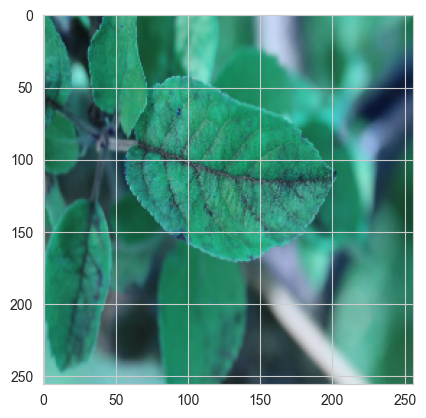

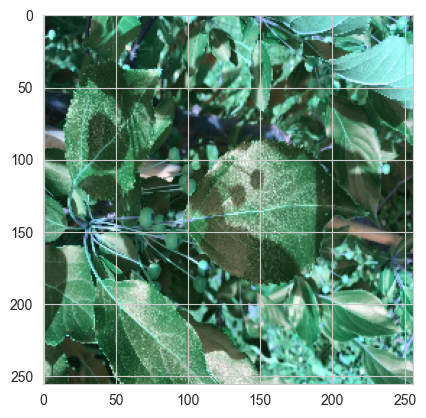

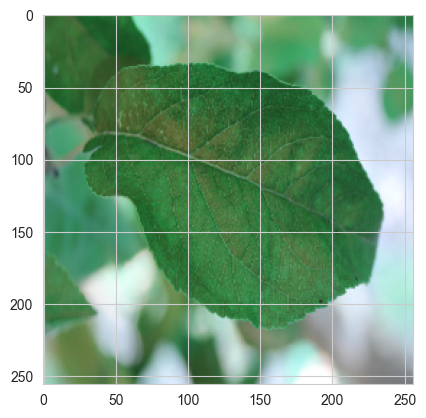

In [39]:
for i in range(0,10):
    plt.imshow(img[i])
    plt.show()

In [33]:
def trainModel():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation=relu, input_shape = (2048,1365,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation = "relu"))
    model.add(Flatten())
    model.add(Dense(2, activation = "softmax"))
    model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

trainModel()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 2048, 1365, 32)    896       
                                                                 
 batch_normalization_2 (Bat  (None, 2048, 1365, 32)    128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 1024, 682, 32)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1024, 682, 32)     0         
                                                                 
 dense (Dense)               (None, 1024, 682, 128)    4224      
                                                                 
 flatten (Flatten)           (None, 89391104)         